In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
pplt.rc.reso='hi'
warnings.filterwarnings('ignore')

In [59]:
FILEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/data'
SAVEDIR = '/ocean/projects/atm200007p/sferrett/Repos/monsoon-pr/figs'
COLORS  = {
    'Eastern Arabian Sea':'#D42028',
    'Central India':'#F2C85E',
    'Northern Bay of Bengal':'#5BA7DA',
    'Central Bay of Bengal':'#1B2C61'}
SAMPLETHRESH = 50

In [61]:
def open_dataset(filename,multi=False,filedir=FILEDIR):
    filepath = f'{filedir}/{filename}'
    if multi==True:
        ds = xr.open_mfdataset(filepath)
    else:
        ds = xr.open_dataset(filepath)
    return ds

def get_bin_mean_pr(monthstats,bintype,samplethresh=SAMPLETHRESH):
    if bintype=='1D':
        Q0 = monthstats.Q0.values
        Q1 = monthstats.Q1.values
        Q0[Q0==0.0] = np.nan
        Q = Q1/Q0
        Q[Q0<samplethresh] = np.nan
        return Q
    if bintype=='2D':
        P0 = monthstats.P0.values
        P1 = monthstats.P1.values
        P0[P0==0.0] = np.nan
        P = P1/P0
        P[P0<samplethresh] = np.nan
        return P

def get_joint_hist(monthstats):
    PE = monthstats.PE
    P0 = monthstats.P0
    capebins   = monthstats.cape
    subsatbins = monthstats.subsat
    jointhist  = PE/(np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0])
    subsatmaxidx,capemaxidx = np.where(PE==np.nanmax(PE))
    subsatmaxidx,capemaxidx = subsatmaxidx[0],capemaxidx[0]
    return jointhist,subsatmaxidx,capemaxidx

def get_thermo_ratio(monthstats,bintype='2D',samplethresh=SAMPLETHRESH):
    capebins   = monthstats.cape.values
    subsatbins = monthstats.subsat.values
    jointhist,subsatmaxidx,capemaxidx = get_joint_hist(monthstats)
    binmeanpr  = get_bin_mean_pr(monthstats,bintype,samplethresh=SAMPLETHRESH)
    while np.isnan(binmeanpr[:subsatmaxidx,:]).all():
        subsatmaxidx = subsatmaxidx+1
        if subsatmaxidx>subsatbins.size-1:
            print('Could not locate point for precipitation sensitivity computation.')
            break
    pra = np.copy(binmeanpr)
    prb = np.copy(binmeanpr)
    prc = np.copy(binmeanpr)
    pra[:] = np.nan
    prb[:] = np.nan
    prc[:] = np.nan
    pra[:subsatmaxidx,capemaxidx:]   = binmeanpr[:subsatmaxidx,capemaxidx:]
    prb[:subsatmaxidx,:capemaxidx+1] = binmeanpr[:subsatmaxidx,:capemaxidx+1]
    prc[subsatmaxidx-1:,capemaxidx:] = binmeanpr[subsatmaxidx-1:,capemaxidx:]
    maska = (np.where(np.isfinite(pra)))
    maskb = (np.where(np.isfinite(prb)))
    maskc = (np.where(np.isfinite(prc)))
    capea   = capebins[maska[1]]
    capeb   = capebins[maskb[1]]
    subsata = subsatbins[maska[0]]
    subsatc = subsatbins[maskc[0]]
    dprcape   = abs(np.nanmean(pra)-np.nanmean(prb))
    dprsubsat = abs(np.nanmean(pra)-np.nanmean(prc))
    dcape     = abs(capea.mean()-capeb.mean())
    dsubsat   = abs(subsata.mean()-subsatc.mean())
    gamma    = np.sqrt(((dprcape/dcape)**2)+((dprsubsat/dsubsat)**2))
    tantheta = (dprcape/dcape)*(dsubsat/dprsubsat)
    return np.arctan(tantheta),gamma

In [ ]:
ds = open_dataset('/processed/binned_stats.nc')

Eastern Arabian Sea:
- 0.6649554232378337,0.7193420442586922
- 17.18210732841866,16.96610490919236
Central India:
- 0.37280387791916414,0.02613488304344131
- 3.760355727548166,4.074192094276946
Northern Bay of Bengal:
- 0.7708107942811976,0.7573093549556557
- 13.406031862928145,28.004893169580345
Central Bay of Bengal:
- 0.854266446091431,0.7913428630469967
- 18.95301974703097,14.568209886521261


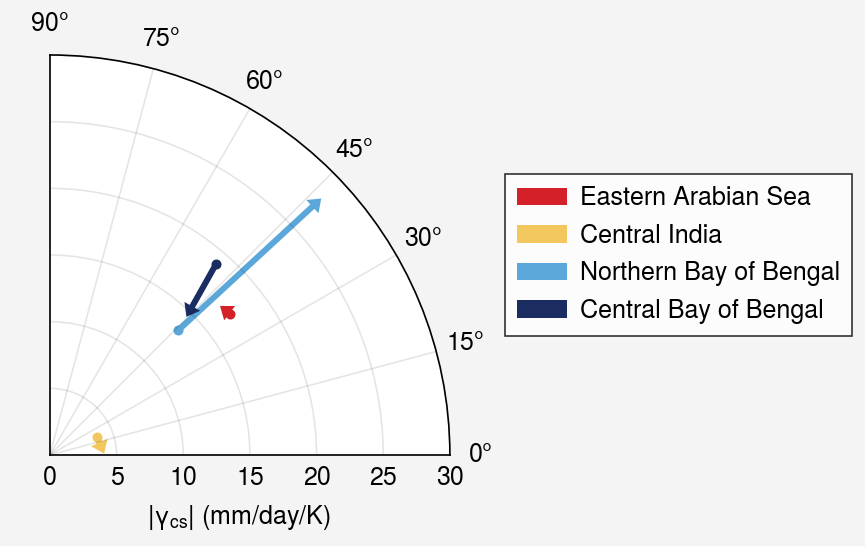

In [65]:
arrowkwargs = dict(scale_units='xy',angles='xy',scale=1,width=0.015,headlength=2,headaxislength=2)
fig,ax = pplt.subplots(nrows=1,ncols=1,proj='polar',refheight=2,refwidth=2)
fig.text(x=0.17,y=0.04,s='|$\gamma_{cs}$| (mm/day/K)')
for region,color in COLORS.items():
    jundata = ds.sel(region=region,month=6)
    juldata = ds.sel(region=region,month=7)
    thetajun,gammajun = get_thermo_ratio(jundata)
    thetajul,gammajul = get_thermo_ratio(juldata)
    print(f'{region}:\n- {thetajun},{thetajul}\n- {gammajun},{gammajul}')
    thetadiff = thetajul-thetajun
    gammadiff = gammajul-gammajun
    ax.scatter(thetajun,gammajun,color=color,marker='.')
    ax.quiver(thetajun,gammajun,thetadiff,gammadiff,color=color,label=region,**arrowkwargs)
ax.format(thetadir='anticlockwise',thetalines=15,thetalim=(0,90),rlim=(0,30))
ax.legend(loc='r',ncols=1)
pplt.show()
# fig.save(f'{SAVEDIR}/fig_4_arrows.png',dpi=300)